We start by getting hold of the image as a numpy array. Original image cropped from https://github.com/ipython/xkcd-font/issues/9#issuecomment-127412261:

In [1]:
import matplotlib.pyplot as plt
hand = plt.imread('../../images/xkcd-font/handwriting_minimal.png')

This is a pretty beefy image, so we will want to cut it down a little whilst doing some development. Once we are happy with the process, we can then use the full image:

In [2]:
print(hand.shape)

(6099, 11429, 3)


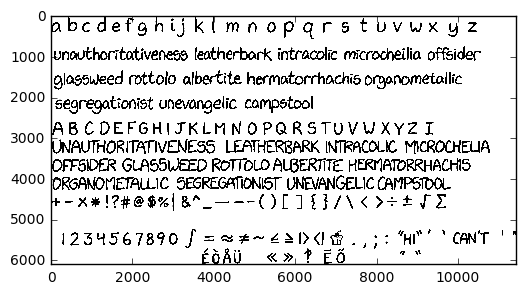

In [3]:
plt.imshow(hand)
plt.show()

Before we even start, notice that some of the characters overlap, and even touch one another. This isn't going to be a clean bounding box type problem:

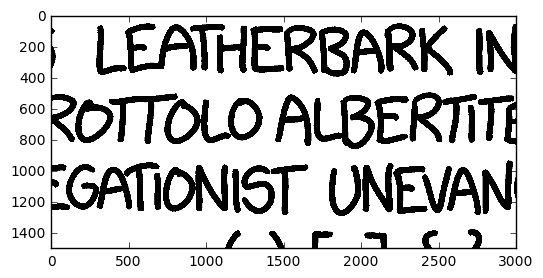

In [9]:
small_image = hand[3000:4500, 4000:7000]
plt.imshow(small_image)
plt.show()

In [10]:
from skimage.color import rgb2gray
from skimage.color.colorlabel import label2rgb
from scipy import ndimage as ndi
import numpy as np

Convert to grayscale, and label the image by distinct marks.

In [11]:
small_image_gray = rgb2gray(small_image)
labels, _ = ndi.label(small_image_gray < 1)

Now convert the labels to RGB so that we can see our different segmentations:

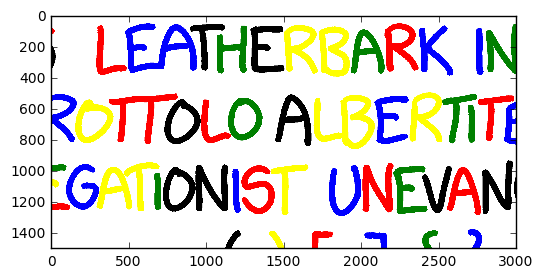

In [13]:
labels = np.ma.masked_equal(labels, 0)
label_img = label2rgb(labels.data, colors=['red', 'blue', 'green', 'black', 'yellow'],
                      bg_label=0, bg_color=(1, 1, 1))
plt.imshow(label_img)
plt.show()

Our first attempt to separate the letters has had some success. Let's compute each glyph's bounding box, and add that to the image. Initially, I tried using ``scipy.ndimage.measurements.extrema`` to give me each label's bounding box, but ended up needing to brute-force it using ```np.where```.

**Note from the future:** * [skimage.measure.regionprops](http://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.regionprops) is the best tool for the job.*

In [14]:
glyph_locations = {}

for i in range(1, labels.max()):
    ys, xs = np.where(labels == i)
    bbox = [xs.min(), ys.min(), xs.max(), ys.max()]
    glyph_locations[i] = bbox

Now that we have the locations of the labels, let's draw a rectangle around each distinct label.

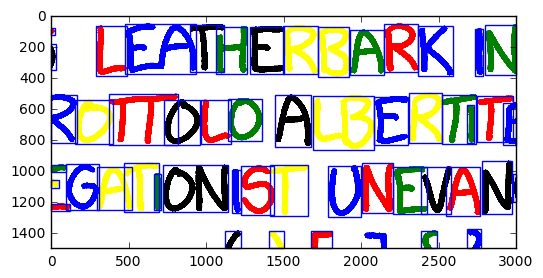

In [15]:
import matplotlib.patches as mpatches

ax = plt.axes()
plt.imshow(label_img)
 
for glyph_i, bbox in glyph_locations.items():
    height, width = bbox[3] - bbox[1], bbox[2] - bbox[0]
    rect = mpatches.Rectangle([bbox[0], bbox[1]], width, height,
                             edgecolor='blue', facecolor='none', transform=ax.transData)
    ax.patches.append(rect)
    
plt.show()